---
# JAX

#### Tutorial by Ferran Jimenez 
---

The contents of this notebook explain the main features of the JAX library. The topics discussed are what follows:

1. JAX's NumPy
    1. Similarities
    2. Differences

3. LAX
    1. What is it?
    2. How to use it
2. Autodifferentiation
4. JIT
    1. What is it?
    2. How to use it
5. Vmap


In [28]:
!pip install tensorflow-datasets
!pip install jax
!pip install jaxlib
!pip install matplotlib
!pip install flax
!pip install optax


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


## NumPy
---
### A. Similarities 

JAX is a Python library that tries to emulate NumPy while enabling automatic differentiation, precompiling and vectorization to perform high-performance tasks. JAX contains a set of numpy like functions and objects inside jax.numpy

In [29]:
import jax.numpy as jnp
import numpy as np

np_identity = np.identity(3)

jnp_identity = jnp.identity(3)

print('NumPy array\n',np_identity)
print('\nJAX array\n',jnp_identity)



NumPy array
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

JAX array
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


NumPy arrays can be operated together with JAX arrays, the resulting arrays becoming JAX arrays

In [30]:
added_arrays = np_identity+jnp_identity

print('JAX and Numpy operation\n', added_arrays)
print('Object type:',type(added_arrays))

JAX and Numpy operation
 [[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]]
Object type: <class 'jaxlib.xla_extension.DeviceArray'>


### B. Differences

Main diferences:

1. No operations over lists or tuples
2. In-Place updates (substitutions and operations)
3. Out of Bounds Indexing
4. Memory overflow (256 in uint8 is 255 still)


#### 1. No operations over lists or tuples

In [31]:
try:
    print(jnp.sum([1.,2.,3.]))
except Exception as e:
    print("Exception! {}".format(e))

Exception! sum requires ndarray or scalar arguments, got <class 'list'> at position 0.


In [32]:
print(jnp.sum(jnp.array([1.,2.,3.])))

6.0


#### 2. In-Place updates (substitution and operations)

We are very used to change certain rows columns or even elements of a numpy array by manualy indicating their indexes in the following manner:

In [33]:
matrix = np.ones((4,4))
print('Before:')
print(matrix)

matrix[:2,::2] = 37 #Substitute the values of the elements for a number

matrix[2:,1::2]+=7 #Add to the values of the elements a number

print('\nAfter:')
print(matrix)

Before:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]

After:
[[37.  1. 37.  1.]
 [37.  1. 37.  1.]
 [ 1.  8.  1.  8.]
 [ 1.  8.  1.  8.]]


This is still possible to do with JAX, however it follows a different syntaxis:

In [34]:
matrix = jnp.ones((4,4))
print('Before:')
print(matrix)

matrix = matrix.at[:2,::2].set(37.) #Substitute the values of the elements for a number

matrix = matrix.at[2:,1::2].add(7.) #Add to the values of the elements a number

print('\nAfter:')
print(matrix)

Before:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]

After:
[[37.  1. 37.  1.]
 [37.  1. 37.  1.]
 [ 1.  8.  1.  8.]
 [ 1.  8.  1.  8.]]


This In-Place updates can also be applied under vector propagation like in Numpy

In [8]:
#In NumPy
np_matrix = np.ones((4,4))
np_matrix[:,0] = np.arange(4)
print('NumPy result:\n',np_matrix)

#In JAX
jnp_matrix = jnp.ones((4,4))
jnp_matrix= jnp_matrix.at[:,0].set(jnp.arange(4))
print('\nJAX result:\n',jnp_matrix)


NumPy result:
 [[0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [2. 1. 1. 1.]
 [3. 1. 1. 1.]]

JAX result:
 [[0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [2. 1. 1. 1.]
 [3. 1. 1. 1.]]


#### 3. Out of Bounds Index

JAX also handles out of Bound indexing of arrays in a different manner to NumPy. Instead of raising an error JAX always returns something. The behaviour is however not well defined

In [9]:
print(jnp.arange(10)[15]) #Index only defined up to 9

9


#### 4. Memory overflow 

Another significant difference is how JAX handles unsafe type casts. when using astype() method. While NumPy has an assigned casting method, JAX may be backen dependent.

In [10]:
print('NumPy: ',np.arange(254.0, 258.0).astype('uint8'))

print('JAX: ',jnp.arange(254.0, 258.0).astype('uint8'))

NumPy:  [254 255   0   1]
JAX:  [254 255 255 255]


## LAX
---
### A. What is it?

All those differences with NumPy and many restrictions that JAX poses come from the fact that jax.numpy is a high-level wrapper to a lower-level API, LAX. It is more powerful yet stricter than usual NumPy. This makes it very important to keep the variables' types in mind at all times when using it. 

In [35]:
from jax import lax

try:
    print(lax.add(1,1.))
except Exception as e:
    print("Exception! {}".format(e))

Exception! lax.add requires arguments to have the same dtypes, got int32, float32. (Tip: jnp.add is a similar function that does automatic type promotion on inputs).


To operate, the API requires type promotion:

In [36]:
print(lax.add(jnp.float32(1),1.))

2.0


LAX is used internally, most of the functionality can be used through jax.numpy without paying any kind of mind to type promotion. 

### Just In Time (JIT) compilation
---

JAX includes Just In Time compilation, which enables sequences of operations to be ran together more efficiently. This is done by precompiling operations using XLA (Accelerated linear Algebra compiler). This however means the use of jit is restricted to functions in which array shapes are static and can fail when implementing certain operations.

In [37]:
from jax import jit

def selu(x, alpha=1.67, lambda_=1.05):
    return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)
jit_selu = jit(selu)
x = jnp.arange(1000000)
%timeit selu(x)
%timeit jit_selu(x)

676 µs ± 110 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
213 µs ± 36.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can observe an increment on speed when jitted, (at time of writting 10 times faster). However in the following examples we will observe where the limits of jit come apparent. 

In [38]:
# Condition on value of x.

def f(x):
    if x > 0:
        return x
    else:
        return 2 * x
    
f_jit = jit(f)
try:
    f_jit(10)  # Should raise an error. 
except Exception as e:
    print("Exception! {}".format(e))

Exception! Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
The error occurred while tracing the function f at /tmp/ipykernel_418621/3016708238.py:3 for jit. This concrete value was not available in Python because it depends on the value of the argument 'x'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError


The error comes from the condition x>0, we can however circumnavigate this by not making use of Booleans. 

In [39]:
def g(x):
    return jnp.where(x>0,x,2*x)
g_jit = jit(g)
try:
    print(g_jit(jnp.array(10)))  # Should not raise an error. 
except Exception as e:
    print("Exception! {}".format(e))

10


For the following function, however, the approach beforehan is not sufficient. As explained in the beggining this is because the shape of a function must remain static.

In [40]:
def get_negatives(x):
    return x[x < 0]

x = jnp.array(np.random.randn(10))

get_negatives(x)
try:
    jit(get_negatives)(x)
except Exception as e:
    print("Exception! {}".format(e))

Exception! Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError


### Vmap \& Autodifferentiation
---

JAX also includes vmap or vectorizing map, which allows the application of a function along array axes. It does so internally to further accelerate computation, when combined with JIT it can achieve similar performance to manually program it.

In [41]:
from jax import grad,vmap,random
import matplotlib.pyplot as plt

key = random.PRNGKey(0)
mat = random.normal(key, (150, 300))
batched_x = random.normal(key, (1000, 300))

@jit
def apply_matrix(v):
    return jnp.dot(mat, v)
@jit
def naively_batched_apply_matrix(v_batched):
    return jnp.stack([apply_matrix(v) for v in v_batched])

vectorized_batched = vmap(apply_matrix)
print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x)


print('Vmap batched')
%timeit vectorized_batched(batched_x)

Naively batched
2.05 ms ± 288 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Vmap batched
581 µs ± 5.23 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


JAX includes a general automatic differentiation system. From a basic gradient function to functions to compute both the Hessian and Jacobian matrices.

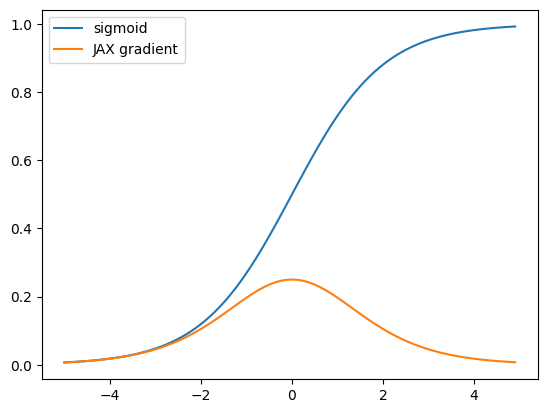

In [42]:
def sigmoid(x):
    return 0.5 * (jnp.tanh(x / 2) + 1)

x = jnp.arange(-5,5,0.1)
y = sigmoid(x)
y2 = vmap(grad(sigmoid))(x)
plt.plot(x,y,label = 'sigmoid')
plt.plot(x,y2,label = 'JAX gradient')
plt.legend()

NumPy also allows for the computation of the gradient of the result of the function. This is not automatic however, and requires of the step of the function. JAX.gradient computes the gradient of the function per se.

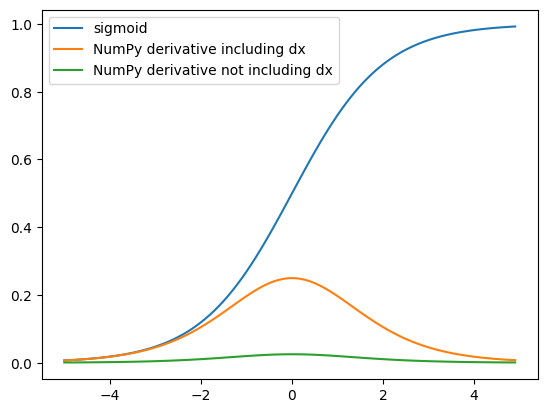

In [19]:
x = np.arange(-5,5,0.1)
y = sigmoid(x)
y2 = np.gradient(sigmoid(x),0.1)
y3 = np.gradient(sigmoid(x))
plt.plot(x,y,label = 'sigmoid')
plt.plot(x,y2,label = 'NumPy derivative including dx')
plt.plot(x,y3,label = 'NumPy derivative not including dx')
plt.legend()

# Linear Regression Training Example

---

4.008714199066162 s
w: 3.00, b: -1.01


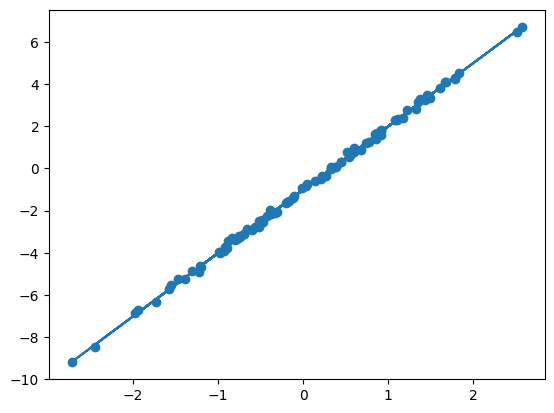

In [43]:
import time

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

def model(theta, x):
    """Computes wx + b on a batch of input x."""
    w, b = theta
    return w * x + b

def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction-y)**2)

def update(theta, x, y, lr=0.1):
    return theta - lr * grad(loss_fn)(theta, x, y)

theta = jnp.array([1., 1.])
start_time = time.time()
for _ in range(1000):
    theta = update(theta, xs, ys)
print(time.time()-start_time,'s')
plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

0.05715441703796387 s
w: 2.99, b: -1.00


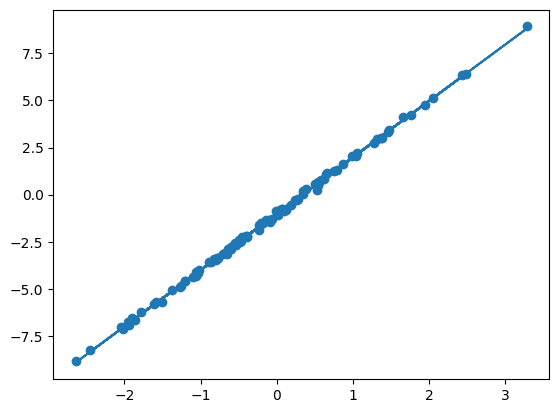

In [44]:
import time
xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise


def model(theta, x):
    """Computes wx + b on a batch of input x."""
    w, b = theta
    return w * x + b

def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction-y)**2)
@jit
def update(theta, x, y, lr=0.1):
    return theta - lr * grad(loss_fn)(theta, x, y)

theta = jnp.array([1., 1.])
start_time = time.time()
for _ in range(1000):
    theta = update(theta, xs, ys)
print(time.time()-start_time,'s')
plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

# Pytrees

---

A useful tool from jax are Pytrees, they are containers which hold leafs. These leafs can have any type, from numbers, string to other containers. They are often used in machine learning storing:

- Model Parameters
- Dataset entries
- RL agent observations



In [22]:
import jax
list_of_lists = [
    [1, 2, 3],
   {'hello': (1, 2),'goodbye':(1,3.2)},
    jnp.array([1, 2, 3, 4])
]


for pytree in list_of_lists:
    leaves = jax.tree_util.tree_leaves(pytree)
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 2, 3]                                     has 3 leaves: [1, 2, 3]
{'hello': (1, 2), 'goodbye': (1, 3.2)}        has 4 leaves: [1, 3.2, 1, 2]
DeviceArray([1, 2, 3, 4], dtype=int32)        has 1 leaves: [DeviceArray([1, 2, 3, 4], dtype=int32)]


In [23]:
print('Operation with a single list of trees\n',jax.tree_map(lambda x: x*2, list_of_lists))

scnd_list = list_of_lists.copy()


print('Operation with a two lists of trees\n',jax.tree_map(lambda x,y: -x+3*y, list_of_lists,scnd_list))

Operation with a single list of trees
 [[2, 4, 6], {'goodbye': (2, 6.4), 'hello': (2, 4)}, DeviceArray([2, 4, 6, 8], dtype=int32)]
Operation with a two lists of trees
 [[2, 4, 6], {'goodbye': (2, 6.400000000000001), 'hello': (2, 4)}, DeviceArray([2, 4, 6, 8], dtype=int32)]


We can use pytrees to store and handle ML parameters

15.809356927871704 s


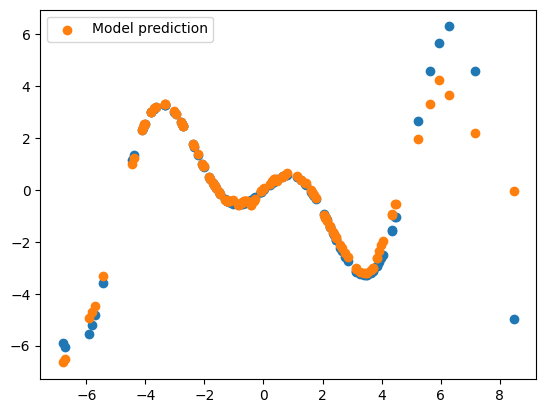

In [24]:
import jax

def init_mlp_params(layer_widths):
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
              dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
              biases=np.ones(shape=(n_out,))
              )
            )
    return params

params = init_mlp_params([1, 128, 128, 1]) #Number of nodes each layer

jax.tree_map(lambda x: x.shape, params)

def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jit
def update(params, x, y):
    grads = jax.grad(loss_fn)(params, x, y)
    # Note that `grads` is a pytree with the same structure as `params`.
    # `jax.grad` is one of the many JAX functions that has
    # built-in support for pytrees.

    # This is handy, because we can apply the SGD update using tree utils:
    return jax.tree_map(
        lambda p, g: p - LEARNING_RATE * g, params, grads
    )

xs = np.random.normal(size=(128, 1))*3
ys = jnp.cos(xs)*xs

start_time = time.time()
for i in range(100000):
    params = update(params, xs, ys)
print(time.time()-start_time,'s')
plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

# Parellel computing

---

In [12]:
key = random.PRNGKey(0)
mat = random.normal(key, (150, 300))
x = random.normal(key, (100000, 300))

@jit
def apply_matrix(v):
    return jnp.dot(mat, v)

vectorized_batched = vmap(apply_matrix)



print('Vmap batched')
%timeit vectorized_batched(batched_x)

NameError: name 'random' is not defined

# MNIST prediction using JAX

---


In [27]:
import jax
import jax.numpy as jnp               # JAX NumPy

from flax import linen as nn          # The Linen API
from flax.training import train_state, checkpoints

import numpy as np                    # Ordinary NumPy
import tensorflow_datasets as tfds    # TFDS for MNIST
import optax

def get_datasets():
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    # Split into training/test sets
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    # Convert to floating-points
    train_ds['image'] = jnp.float32(train_ds['image']) / 255.0
    test_ds['image'] = jnp.float32(test_ds['image']) / 255.0
    return train_ds, test_ds

@jax.jit
def loss_fn(params):
    logits = model.apply({'params': params}, batch['image'])
    loss = jnp.mean(optax.softmax_cross_entropy(
        logits=logits,
        labels=jax.nn.one_hot(batch['label'], num_classes=10)))
    return loss, logits


class CNN(nn.Module):
    @nn.compact
    # Provide a constructor to register a new parameter 
    # and return its initial value
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1)) # Flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)    # There are 10 classes in MNIST
        return x

training_ds ,test_ds = get_datasets()

rnd = jax.random.PRNGKey(0)
rnd,subkey = jax.random.split(rnd)

model = CNN()
params = model.init(subkey,jnp.ones([1,28,28,1]))['params']
tx = optax.sgd(learning_rate=0.001,momentum=0.5)
state = train_state.TrainState.create(apply_fn=model.apply,params=params,tx=tx)
num_epochs = 10
batch_size = 100

for epoch in range(1,num_epochs+1):
    # Use a separate PRNG key to permute image data during shuffling
    rnd, input_rng = jax.random.split(rnd)
    #Let's now train it
    train_ds_size = len(training_ds['image'])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rnd, len(training_ds['image']))
    perms = perms[:steps_per_epoch * batch_size]  # Skip an incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    batch_metrics = []
    loss = 0
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in training_ds.items()}
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss_i, logits), grads = grad_fn(state.params)
        state = state.apply_gradients(grads=grads)
        loss +=loss_i
    print('Epoch {} loss = {}'.format(epoch,loss))

CKPT_DIR = 'ckpts'
checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=2)

Epoch 1 loss = 1182.6591796875
Epoch 2 loss = 477.5924377441406
Epoch 3 loss = 125.42098999023438
Epoch 4 loss = 53.53689193725586
Epoch 5 loss = 29.664846420288086
Epoch 6 loss = 18.94552993774414
Epoch 7 loss = 13.274672508239746
Epoch 8 loss = 9.937272071838379
Epoch 9 loss = 7.79520845413208
Epoch 10 loss = 6.3302741050720215


'ckpts/checkpoint_2'

To test the model, we can first load the model

In [ ]:
import jax
import jax.numpy as jnp               # JAX NumPy
import matplotlib.pyplot as plt

from flax import linen as nn          # The Linen API
from flax.training import train_state,checkpoints
from flax.core import freeze, unfreeze

import numpy as np                    # Ordinary NumPy
import tensorflow_datasets as tfds    # TFDS for MNIST
import optax


class CNN(nn.Module):
  @nn.compact
  # Provide a constructor to register a new parameter
  # and return its initial value
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # Flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)  # There are 10 classes in MNIST
    return x

def get_datasets():
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  # Split into training/test sets
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  # Convert to floating-points
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.0
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.0
  return train_ds, test_ds

_ ,test_ds = get_datasets()

print(np.shape(test_ds['image']))

CKPT_DIR = 'ckpts'
model = CNN()
rnd,subkey = jax.random.split(jax.random.PRNGKey(0))
params = model.init(subkey,jnp.ones([1,28,28,1]))['params']
params = unfreeze(params)
params = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR,target = None)['params']
params = freeze(params)

tx = optax.sgd(learning_rate=0.001,momentum=0.5)
state = train_state.TrainState.create(apply_fn=model.apply,params=params,tx=tx)
state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR,target = state)
im = jnp.array([test_ds['image'][np.random.randint(0,10000)]])

pred = np.argmax(model.apply({'params': params},im)[0])
plt.figure(str(pred))
plt.title(str(pred))
plt.imshow(im[0])
plt.show()


In [11]:
import jax.numpy as jnp
import numpy as np
from jax import jit,grad,random,vmap


def prod(mat_a,mat_b):
    return mat_a@mat_b

jit_prod = jit(prod)

mat_a = np.random.random((30000,100))
mat_b = np.random.random((100,780))

#%timeit jit_prod(mat_a,mat_b)
#%timeit prod(mat_a,mat_b)
print(type(prod(mat_a,mat_b)))
print(type(jit_prod(mat_a,mat_b)))



key = random.PRNGKey(0)
mat = random.normal(key, (150, 300))
x = random.normal(key, (300, 100000))


def apply_matrix(v):
    return jnp.dot(mat, v)

def naively_batched_apply_matrix(v_batched):
    return jnp.stack([apply_matrix(v) for v in v_batched])



vectorized_batched = vmap(apply_matrix)

jit_vectorized_batched = jit(vectorized_batched)

print('Simple')
%timeit apply_matrix(x)
print('Vmap batched')
%timeit vectorized_batched(x)

print('Jitted Vmap batched')
%timeit jit_vectorized_batched(x)

<class 'numpy.ndarray'>
<class 'jaxlib.xla_extension.DeviceArray'>
Simple


TypeError: Incompatible shapes for dot: got (150, 300) and (100000, 300).

In [2]:
@jit
def apply_matrix(v):
    return jnp.dot(mat, v)

def naively_batched_apply_matrix(v_batched):
    return jnp.stack([apply_matrix(v) for v in v_batched])
key = random.PRNGKey(0)
mat = random.normal(key, (150, 300))
x = random.normal(key, (100000, 300))

%timeit naively_batched_apply_matrix(x)

8.76 s ± 84.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
